In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import random
import matplotlib.pyplot as plt
print(tf.test.gpu_device_name())
import os
from tensorflow.keras.callbacks import Callback
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools

from jupyterthemes import jtplot
jtplot.style(theme='monokai',context="notebook",ticks=True, grid=False)
jtplot.style(context='talk', fscale=1.2, spines=False, gridlines='--')
jtplot.style(figsize=(6, 4.5))


/device:GPU:0


In [2]:
def build_graphics(history):
    acc=history.history["accuracy"]
    val_acc=history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(len(acc))

    plt.plot(epochs , acc , "r",label="Training_accuracy ")
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()

    plt.show()

    plt.plot(epochs , loss , "r",label="Training_loss ")
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend(loc=0)
    plt.figure()
def build_graphics_custom(history):
    acc=history.history["cust_acc"]
    val_acc=history.history["val_cust_acc"]


    epochs = range(len(acc))

    plt.plot(epochs , acc , "r",label="Training_custom_accuracy ")
    plt.plot(epochs, val_acc, 'b', label='Validation_custom_accuracy')
    plt.title('Training and validation custom accuracy')
    plt.legend(loc=0)
    plt.figure()

    plt.show()
    plt.figure()

In [3]:
def plot_confusion_matrix(model,valid_data,classes,threshold=0.5,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        y_pred = np.asarray(model.predict(valid_data))          

        y_pred= [np.where(num == np.amax(num))[0] for num in y_pred] 
        y_true = valid_data.classes
        count=0
        for i in range(len(y_pred)):
            if y_pred[i]==y_true[i]:
                count+=1
       

        cm = confusion_matrix(valid_data.classes,y_pred)
        
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "black")
        plt.grid(False)
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

In [4]:
# PATH FOLDERS
path_IMAGES = "/home/vladislav/PycharmProjects/tftest/Images"
path_train = "/home/vladislav/PycharmProjects/tftest/Images/Train"
path_validation = "/home/vladislav/PycharmProjects/tftest/Images/Validation"

train_len=len(os.listdir('/home/vladislav/PycharmProjects/tftest/Images/Train/0_without_mask'))
valid_len=len(os.listdir('/home/vladislav/PycharmProjects/tftest/Images/Validation/0_without_mask'))

In [5]:
class BestWeightsRemember(tf.keras.callbacks.Callback):
  def __init__(self,patience_stop_train=50,patience_decrease_lr=15,decrease_factor=0.3):

    super(BestWeightsRemember,self).__init__()
    self.patience_stop_train = patience_stop_train 
    self.patience_decrease_lr = patience_decrease_lr
    self.decrease_factor = decrease_factor
    self.best_weights = None


  def on_train_begin(self,logs=None):
    self.wait = 0 
    self.stopped_epoch=0
    self.best_acc = -1
    self.best_train_acc = -1
    self.reduced_lr_flag = False 

  def on_epoch_end(self,epoch,logs=None):

    current_acc = logs.get("val_cust_acc")
    if np.less(self.best_acc,current_acc) or (np.equal(self.best_acc,current_acc) and (np.less(self.best_train_acc,logs.get("cust_acc")))  ):
      self.best_acc = current_acc 
      self.wait=0
      self.best_weights = self.model.get_weights()
      self.reduced_lr_flag = False 
      self.best_train_acc=logs.get("cust_acc")

    elif self.wait < self.patience_decrease_lr :    
      self.wait+=1 

    elif self.wait<self.patience_stop_train :
      if not self.reduced_lr_flag :
        if not hasattr(self.model.optimizer , "lr"):
          raise ValueError("Optimizer haven't any lr attributes")
        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        schedeled_lr = self.lr_schedule(epoch,lr)
        tf.keras.backend.set_value(self.model.optimizer.lr,schedeled_lr)
        print(f"Reduced lr --> {schedeled_lr}")
        self.reduced_lr_flag = True
      self.wait+=1 
    else :  
        self.stopped_epoch = epoch 
        self.model.stop_training = True 
        self.model.set_weights(self.best_weights)
        
  def lr_schedule(self,epoch,lr):
    return lr*self.decrease_factor
      
  def on_train_end(self,logs = None ):
    if self.stopped_epoch >0:
      print("EarlyStopping ! *Saved best waights*")    
  
custom_callback = BestWeightsRemember()

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
steps_per_epoch = train_len//batch_size+1
validation_steps = valid_len//batch_size+1
print(f"Training steps per epoch : {steps_per_epoch}")
print(f"Validation steps per epoch : {validation_steps}")

train_gen = ImageDataGenerator(
    #rescale = 1/255.0,
                               samplewise_std_normalization=True,
                               horizontal_flip = True,
                             brightness_range=[0.8,1.2],
                               rotation_range=30,
                               zoom_range=0.1,
                               fill_mode = "nearest",
                               width_shift_range=0.15, 
                                 height_shift_range=0.15,
                              )

train_generator = train_gen.flow_from_directory(path_train,
                                               batch_size = batch_size ,
                                               class_mode = "categorical",
                                               target_size = (224,224)
                                               )

valid_gen = ImageDataGenerator(
    #rescale = 1/255.0
    samplewise_std_normalization=True,
)

valid_generator = valid_gen.flow_from_directory(path_validation,
                                               batch_size = batch_size ,
                                               class_mode = "categorical",
                                               target_size = (224,224)
                                               )
valid_generator_cm = valid_gen.flow_from_directory(path_validation,
                                               batch_size = batch_size ,
                                               class_mode = "categorical",
                                               target_size = (224,224),
                                                 shuffle=False 
                                               )

Training steps per epoch : 95
Validation steps per epoch : 21
Found 10513 images belonging to 4 classes.


/home/vladislav/anaconda3/envs/tftestenv/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:355: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 2220 images belonging to 4 classes.
Found 2220 images belonging to 4 classes.


In [7]:
callback1 = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_cust_acc', factor=0.3, patience=10,  
    min_delta=0.001 )

'''callback2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_cust_acc', min_delta=0.001, patience=35,  restore_best_weights=True
)'''

"callback2 = tf.keras.callbacks.EarlyStopping(\n    monitor='val_cust_acc', min_delta=0.001, patience=35,  restore_best_weights=True\n)"

In [8]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
import tensorflow

#!!!!!!!!!!!!!!!!!!!1
tensorflow.random.set_seed(5)

base_model_MobileNet = MobileNet(input_shape=(224,224,3),weights = "imagenet",include_top=False)

#4096 1028 1 
def build_model(base_model,to_unfreeze=None):
    x = base_model.output  
    
    x = tf.keras.layers.Flatten()(x)
    
    
    x = tf.keras.layers.Dropout(0.5)(x) # 0.5
    x = tf.keras.layers.Dense(4096,activation = "relu")(x)
    x = tf.keras.layers.Dropout(0.35)(x) # 0.35
    x = tf.keras.layers.Dense(4096,activation = "relu")(x)
    x = tf.keras.layers.Dropout(0.35)(x) # 0.35
    x = tf.keras.layers.Dense(1028,activation = "relu")(x)
    x = tf.keras.layers.Dropout(0.25)(x) #0.25
    x = tf.keras.layers.Dense(128,activation = "relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x) # 0.2
    y = tf.keras.layers.Dense(4,activation="softmax")(x)
    model = Model(inputs=base_model.input, outputs=y)
    
    if to_unfreeze:
        for layer in base_model.layers[:len(base_model.layers)-to_unfreeze]:
             layer.trainable=False
    else:
        for layer in base_model.layers:
            # train batch normalization layers 
            if "bn" in layer.name:
                layer.trainable=True
                layer.momentum = 0.9
            else :
                layer.trainable=False
    model.summary()
    return model

transfer_MobileNet=build_model(base_model_MobileNet)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [9]:
def cust_acc(y_pred,y_true):
    y_pred_one_hot = tf.one_hot(tf.argmax(y_pred, axis = 1), depth = 4)
    y_true_one_hot = tf.one_hot(tf.argmax(y_true, axis = 1), depth = 4)
    def mask_prediction(y):

        bs=tf.shape(y)[0]
       
        tensor_left_3_el = tf.cast(tf.slice(y,[0,0],[bs,3]),tf.int32)
        tensor_right_2_el = tf.slice(y,[0,3],[bs,1])
        to_add = tf.concat([tf.cast(tensor_right_2_el,dtype=tf.int32),tf.zeros((bs,2),dtype=tf.int32)],1)
        res = tf.add(tensor_left_3_el,to_add)
        return res  
    
    Y_pred=mask_prediction(y_pred_one_hot)
    Y_true=mask_prediction(y_true_one_hot)
    equal_t = tf.equal(Y_pred, Y_true)
    reduce_t = tf.cast(tf.reduce_all(equal_t, axis=1),tf.float32) 
    return tf.reduce_mean(reduce_t) 
   


In [10]:

from tensorflow.keras.optimizers import Adam 
transfer_MobileNet.compile(loss="categorical_crossentropy",
              optimizer=Adam(0.0005),# 0.001 best rate 
              metrics = ['accuracy',cust_acc])


history_transfer_MobileNet=transfer_MobileNet.fit(train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs= 200,
    verbose = 1,
    validation_data=valid_generator,
    validation_steps= validation_steps,
     class_weight = {0:1, 1:1, 2:1, 3:3},
                callbacks=[custom_callback]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 95 steps, validate for 21 steps
Epoch 1/200
95/95 [==============================] - 33s 352ms/step - loss: 3.3611 - accuracy: 0.2823 - cust_acc: 0.4403 - val_loss: 1.3411 - val_accuracy: 0.3199 - val_cust_acc: 0.6414
Epoch 2/200
95/95 [==============================] - 31s 330ms/step - loss: 1.3215 - accuracy: 0.4743 - cust_acc: 0.6694 - val_loss: 0.9719 - val_accuracy: 0.8006 - val_cust_acc: 0.8542
Epoch 3/200
95/95 [==============================] - 31s 330ms/step - loss: 1.0628 - accuracy: 0.6625 - cust_acc: 0.7921 - val_loss: 0.6708 - val_accuracy: 0.7485 - val_cust_acc: 0.9077
Epoch 4/200
95/95 [==============================] - 31s 323ms/step - loss: 0.9419 - accuracy: 0.7207 - cust_acc: 0.8349 - val_loss: 0.7870 - val_accuracy: 0.8021 - val_cust_acc: 0.8988
Epoch 5/200
95/95 [==============================] - 31s 324ms/step - loss: 0.9054 - accuracy: 0.7319 - cust_acc: 0.8247 - val_loss: 0.9127 - val_accuracy: 0.6949 -

Epoch 44/200
95/95 [==============================] - 31s 328ms/step - loss: 0.4402 - accuracy: 0.8806 - cust_acc: 0.9240 - val_loss: 0.5457 - val_accuracy: 0.8720 - val_cust_acc: 0.9405
Epoch 45/200
95/95 [==============================] - 31s 330ms/step - loss: 0.4090 - accuracy: 0.8914 - cust_acc: 0.9362 - val_loss: 0.5373 - val_accuracy: 0.8631 - val_cust_acc: 0.9405
Epoch 46/200
95/95 [==============================] - 31s 327ms/step - loss: 0.4190 - accuracy: 0.8944 - cust_acc: 0.9408 - val_loss: 0.5816 - val_accuracy: 0.8929 - val_cust_acc: 0.9494
Epoch 47/200
95/95 [==============================] - 31s 323ms/step - loss: 0.4327 - accuracy: 0.8853 - cust_acc: 0.9296 - val_loss: 0.5054 - val_accuracy: 0.8869 - val_cust_acc: 0.9524
Epoch 48/200
95/95 [==============================] - 31s 330ms/step - loss: 0.3918 - accuracy: 0.8970 - cust_acc: 0.9441 - val_loss: 0.5893 - val_accuracy: 0.8854 - val_cust_acc: 0.9479
Epoch 49/200
95/95 [==============================] - 30s 312ms/s

95/95 [==============================] - 31s 325ms/step - loss: 0.2479 - accuracy: 0.9355 - cust_acc: 0.9632 - val_loss: 0.6530 - val_accuracy: 0.8929 - val_cust_acc: 0.9524
Epoch 88/200
95/95 [==============================] - 31s 326ms/step - loss: 0.2319 - accuracy: 0.9368 - cust_acc: 0.9602 - val_loss: 0.6292 - val_accuracy: 0.8780 - val_cust_acc: 0.9464
Epoch 89/200
95/95 [==============================] - 31s 325ms/step - loss: 0.2933 - accuracy: 0.9276 - cust_acc: 0.9539 - val_loss: 0.7051 - val_accuracy: 0.8795 - val_cust_acc: 0.9375
Epoch 90/200
95/95 [==============================] - 32s 332ms/step - loss: 0.2704 - accuracy: 0.9332 - cust_acc: 0.9576 - val_loss: 0.6345 - val_accuracy: 0.9062 - val_cust_acc: 0.9613
Epoch 91/200
95/95 [==============================] - 31s 325ms/step - loss: 0.2396 - accuracy: 0.9372 - cust_acc: 0.9661 - val_loss: 0.6238 - val_accuracy: 0.9003 - val_cust_acc: 0.9598
Epoch 92/200
95/95 [==============================] - 31s 326ms/step - loss: 0

Epoch 130/200
95/95 [==============================] - 31s 325ms/step - loss: 0.1934 - accuracy: 0.9500 - cust_acc: 0.9684 - val_loss: 0.7408 - val_accuracy: 0.8973 - val_cust_acc: 0.9539
Epoch 131/200
95/95 [==============================] - 31s 326ms/step - loss: 0.1742 - accuracy: 0.9533 - cust_acc: 0.9668 - val_loss: 0.7190 - val_accuracy: 0.8899 - val_cust_acc: 0.9464
Epoch 132/200
95/95 [==============================] - 31s 329ms/step - loss: 0.1775 - accuracy: 0.9523 - cust_acc: 0.9704 - val_loss: 0.7736 - val_accuracy: 0.8824 - val_cust_acc: 0.9449
Epoch 133/200
95/95 [==============================] - 32s 333ms/step - loss: 0.1996 - accuracy: 0.9478 - cust_acc: 0.9704 - val_loss: 0.7135 - val_accuracy: 0.8958 - val_cust_acc: 0.9568
Epoch 134/200
95/95 [==============================] - 31s 328ms/step - loss: 0.1983 - accuracy: 0.9493 - cust_acc: 0.9711 - val_loss: 0.6470 - val_accuracy: 0.8914 - val_cust_acc: 0.9509
Epoch 135/200
95/95 [==============================] - 32s 3

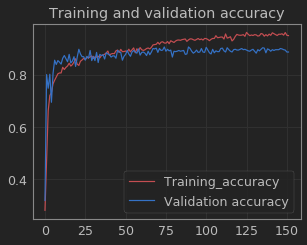

<Figure size 345.6x259.2 with 0 Axes>

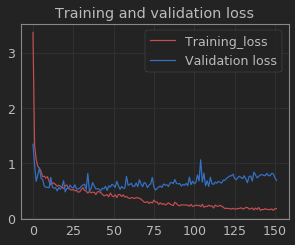

<Figure size 345.6x259.2 with 0 Axes>

In [11]:
build_graphics(history_transfer_MobileNet)

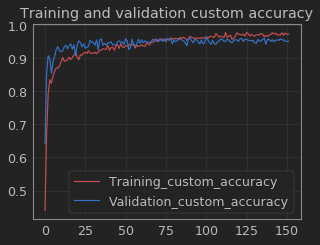

<Figure size 345.6x259.2 with 0 Axes>

<Figure size 345.6x259.2 with 0 Axes>

In [12]:
build_graphics_custom(history_transfer_MobileNet)

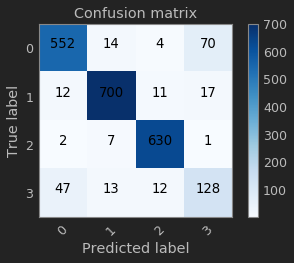

In [13]:
plot_confusion_matrix(transfer_MobileNet,valid_generator_cm,range(4))

In [14]:
weights = transfer_MobileNet.get_weights() #not fine-tuned


In [41]:
transfer_MobileNet.set_weights(weights)

In [38]:
transfer_MobileNet.set_weights(weights)
def unfreeze_layers(model,unfreeze):    
    for layer in model.layers[len(model.layers)-unfreeze:]:
        layer.trainable = True         
    
unfreeze_layers(transfer_MobileNet,24)
print("Train layers :",len(transfer_MobileNet.trainable_variables))
for i, layer in enumerate(transfer_MobileNet.layers):
   print(i,"-", layer.name,"-",layer.trainable)

from tensorflow.keras.optimizers import SGD
transfer_MobileNet.compile(loss="categorical_crossentropy",
              optimizer=SGD(lr=0.000001,momentum=0.9),
              metrics = ['accuracy',cust_acc])
transfer_MobileNet.summary()

Train layers : 68
0 - input_1 - False
1 - conv1_pad - False
2 - conv1 - False
3 - conv1_bn - True
4 - conv1_relu - False
5 - conv_dw_1 - False
6 - conv_dw_1_bn - True
7 - conv_dw_1_relu - False
8 - conv_pw_1 - False
9 - conv_pw_1_bn - True
10 - conv_pw_1_relu - False
11 - conv_pad_2 - False
12 - conv_dw_2 - False
13 - conv_dw_2_bn - True
14 - conv_dw_2_relu - False
15 - conv_pw_2 - False
16 - conv_pw_2_bn - True
17 - conv_pw_2_relu - False
18 - conv_dw_3 - False
19 - conv_dw_3_bn - True
20 - conv_dw_3_relu - False
21 - conv_pw_3 - False
22 - conv_pw_3_bn - True
23 - conv_pw_3_relu - False
24 - conv_pad_4 - False
25 - conv_dw_4 - False
26 - conv_dw_4_bn - True
27 - conv_dw_4_relu - False
28 - conv_pw_4 - False
29 - conv_pw_4_bn - True
30 - conv_pw_4_relu - False
31 - conv_dw_5 - False
32 - conv_dw_5_bn - True
33 - conv_dw_5_relu - False
34 - conv_pw_5 - False
35 - conv_pw_5_bn - True
36 - conv_pw_5_relu - False
37 - conv_pad_6 - False
38 - conv_dw_6 - False
39 - conv_dw_6_bn - True
40 -

In [ ]:
history_transfer_MobileNet=transfer_MobileNet.fit(train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs= 150,
    verbose = 1,
    validation_data=valid_generator,
    validation_steps= validation_steps,
    class_weight = {0:1, 1:1 , 2:1,3:3},
                                                  callbacks=[custom_callback]                                              
)

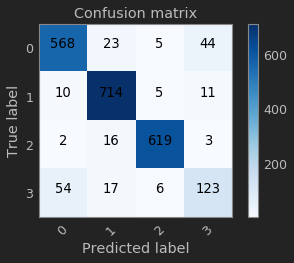

In [34]:
plot_confusion_matrix(transfer_MobileNet,valid_generator_cm,range(4))

In [29]:
transfer_MobileNet.set_weights(weights)

Found 750 images belonging to 4 classes.
  ...
    to  
  ['...']
24/24 [==============================] - 5s 194ms/step - loss: 1.0939 - accuracy: 0.8347 - cust_acc: 0.9583


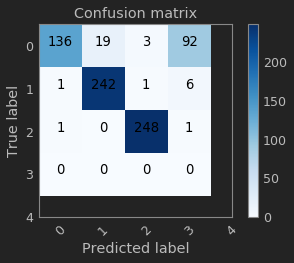

In [17]:
test_gen = ImageDataGenerator(samplewise_std_normalization=True,)
test_generator = test_gen.flow_from_directory('/home/vladislav/PycharmProjects/tftest/Images/test_main',
                                              
                                               class_mode = "categorical",
                                               target_size = (224,224), 
                                              shuffle = False 
                                               )
transfer_MobileNet.evaluate(test_generator)
plot_confusion_matrix(transfer_MobileNet,test_generator,range(5))


In [23]:
transfer_MobileNet.set_weights(weights)
test_gen = ImageDataGenerator(samplewise_std_normalization=True,)
test_generator = test_gen.flow_from_directory('/home/vladislav/PycharmProjects/tftest/Images/Test',
                                              
                                               class_mode = "categorical",
                                               target_size = (224,224), 
                                              shuffle = False 
                                               )
transfer_MobileNet.evaluate(test_generator)
plot_confusion_matrix(transfer_MobileNet,test_generator,range(5))

NameError: name 'weights' is not defined

In [18]:
transfer_MobileNet.save('MobileNet_1_1_1_3.h5')
transfer_MobileNet.save_weights('MobileNetWeights_1_1_1_3.h5')

In [43]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import numpy as np 
from PIL import Image
with_mask_dr='/home/vladislav/PycharmProjects/tftest/Images/test_main/1_with/'
without_mask_dir='/home/vladislav/PycharmProjects/tftest/Images/test_main/0_wthout/'
without_preson_dir = '/home/vladislav/PycharmProjects/tftest/Images/test_main/2_withot_person/'
with_mask = os.listdir(with_mask_dr)
without_mask = os.listdir(without_mask_dir)
without_preson = os.listdir(without_preson_dir)

size = len(with_mask)
for i in range(size):
    with_mask[i]=Image.open(with_mask_dr+with_mask[i]).resize((224,224))
    without_mask[i]=Image.open(without_mask_dir+without_mask[i]).resize((224,224))
    without_preson[i]=Image.open(without_preson_dir+without_preson[i]).resize((224,224))

In [44]:
miss_with = []
miss_without = []
miss_person = []
reslt=[]
# 0 maska ; 1 - without
arr=np.asarray(with_mask[1]).reshape(1,224,224,3)

for i in range(size):   
    try :
        
        x=np.asarray(with_mask[i]).reshape(1,224,224,3)
    except:
        continue 
    if not np.where(transfer_MobileNet.predict(x/np.std(x))[0] == \
              np.amax(transfer_MobileNet.predict(x/np.std(x))[0]))[0][0] == 1     : 
        miss_with.append(i)
        continue
    try :    
        y=np.asarray(without_mask[i]).reshape(1,224,224,3)
    except:
        continue 
    if not np.where(transfer_MobileNet.predict(y/np.std(y))[0] == \
              np.amax(transfer_MobileNet.predict(y/np.std(y))[0]))[0][0]  in (0,3) :
        miss_without.append(i)
        continue
    z= np.asarray(without_preson[i]).reshape(1,224,224,3)
    if not np.where(transfer_MobileNet.predict(z/np.std(z))[0] == \
              np.amax(transfer_MobileNet.predict(z/np.std(z))[0]))[0][0] == 2 :
        miss_person.append(i)
        continue

In [24]:
print(len(miss_with+miss_without))

40


Said - without mask ,really  with it


IndexError: list index out of range

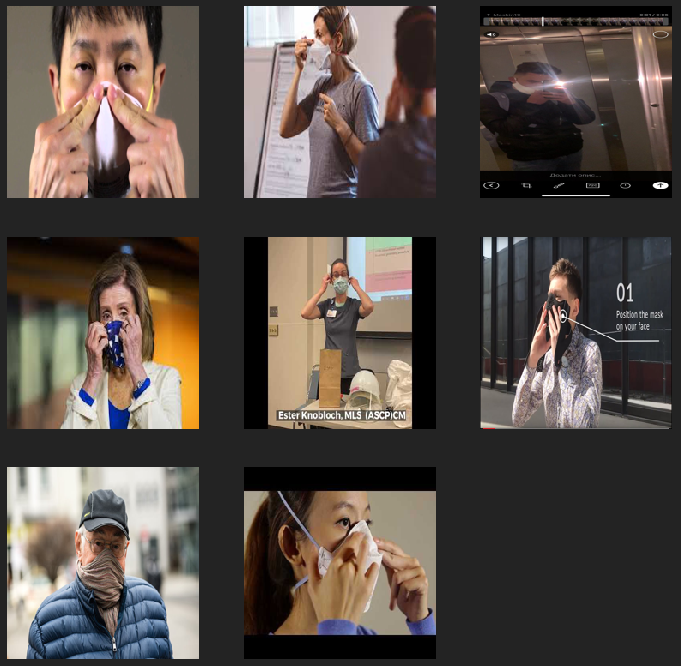

In [28]:
def pred_missclass_visualizations(nrows,ncols):
    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 4)
    for i in range(nrows*ncols):
      sp = plt.subplot(nrows, ncols,i+1)
      sp.axis('Off') # Don't show axes (or gridlines)
      plt.imshow(with_mask[miss_with[i]])
    plt.show()
print("Said - without mask ,really  with it")
pred_missclass_visualizations(3,3)

Said - with, really - without


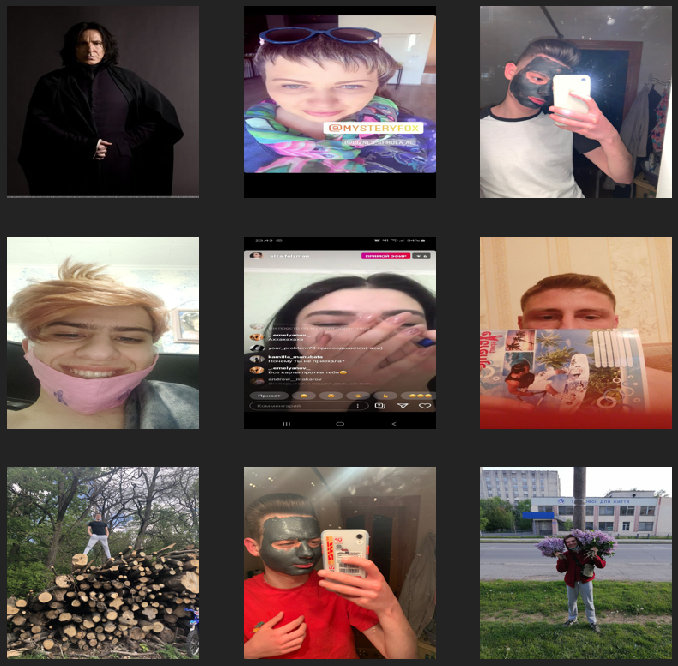

In [46]:
def pred_missclass_visualizations(nrows,ncols):
    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 4)
    for i in range(nrows*ncols):
        sp = plt.subplot(nrows, ncols,i+1)
        sp.axis('Off') # Don't show axes (or gridlines)
        plt.imshow(without_mask[miss_without[i]])
    plt.show()
print("Said - with, really - without")
pred_missclass_visualizations(3,3)

Said - without , really - without


IndexError: list index out of range

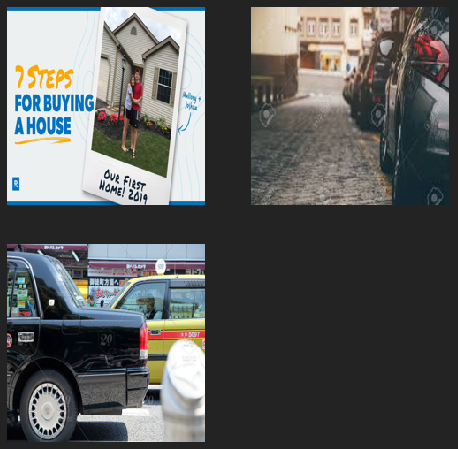

In [20]:
def pred_missclass_visualizations(nrows,ncols):
    fig = plt.gcf()
    fig.set_size_inches(ncols * 4, nrows * 4)
    for i in range(nrows*ncols):
        sp = plt.subplot(nrows, ncols,i+1)
        sp.axis('Off') # Don't show axes (or gridlines)
        plt.imshow(without_preson[miss_person[i]])
    plt.show()
print("Said - without , really - without")
pred_missclass_visualizations(2,2)

In [ ]:
model=transfer_MobileNet
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
'''cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]

img_path = random.choice(cat_img_files + dog_img_files)'''
img = load_img('/home/vladislav/PycharmProjects/tftest/Images/Test/1_with_mask/32810270872+.jpg', target_size=(224, 224))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 